# β-VAE on MNIST

In [ ]:
#setup, 10 epochs
import math, random, time
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); 
np.random.seed(SEED); 
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)


EPOCHS      = 10
BATCH_SIZE  = 128
LR          = 1e-3
BETA        = 4.0   #B-VAE
LATENT_DIM  = 16    


Device: cpu


In [ ]:
#MNIST
transform = transforms.ToTensor()  

train_ds = datasets.MNIST(root="./data", train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  
                          num_workers=2, pin_memory=True)

test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, 
                          num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)} | Test batches: {len(test_loader)}")

x,_ = next(iter(train_loader))

print("Tensor range:", float(x.min()), "→", float(x.max()), "| shape:", tuple(x.shape))


Train batches: 469 | Test batches: 79
Tensor range: 0.0 → 1.0 | shape: (128, 1, 28, 28)


In [ ]:
#Model (Conv VAE)
class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(inplace=True),
        )
        self.flatten_dim = 64 * 7 * 7
        self.fc_mu     = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(x.size(0), -1)
        mu      = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1), 
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(32, 1,  3, 2, 1, output_padding=1),
        )

    def forward(self, z):
        h = self.fc(z).view(z.size(0), 64, 7, 7)
        logits = self.deconv(h)
        return logits

class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    @staticmethod
    def reparameterize(mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        logits = self.decoder(z)
        return logits, mu, log_var

model = VAE(LATENT_DIM).to(DEVICE)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
#ELBO Loss and optimizwer
def elbo_loss(x, logits, mu, log_var, beta=1.0):
    bce = F.binary_cross_entropy_with_logits(logits, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    batch = x.size(0)
    bce = bce / batch
    kl  = kl  / batch
    loss = bce + beta * kl
    return loss, bce, kl

optimizer = torch.optim.Adam(model.parameters(), lr=LR)


def train_step(batch, beta=BETA):
    model.train()
    x, _ = batch
    x = x.to(DEVICE)
    optimizer.zero_grad(set_to_none=True)
    logits, mu, log_var = model(x)
    loss, bce, kl = elbo_loss(x, logits, mu, log_var, beta=beta)
    loss.backward()
    optimizer.step()
    return loss.item(), bce.item(), kl.item()

@torch.no_grad()
def eval_step(batch, beta=BETA):
    model.eval()
    x, _ = batch
    x = x.to(DEVICE)
    logits, mu, log_var = model(x)
    loss, bce, kl = elbo_loss(x, logits, mu, log_var, beta=beta)
    return loss.item(), bce.item(), kl.item()

In [ ]:
#Training 10 epochs
history = {
    "train_total": [], 
    "train_bce": [], 
    "train_kl": [], 
    "test_total": [], 
    "test_bce": [], 
    "test_kl": []
}

for epoch in range(1, EPOCHS+1):
    # Trainng
    t_tot = t_bce = t_kl = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]"):
        L, B, K = train_step(batch, beta=BETA)
        t_tot += L; t_bce += B; t_kl += K
    n_train = len(train_loader)
    history["train_total"].append(t_tot / n_train)
    history["train_bce"].append(t_bce / n_train)
    history["train_kl"].append(t_kl / n_train)

    e_tot = e_bce = e_kl = 0.0
    for batch in tqdm(test_loader, desc=f"Epoch {epoch}/{EPOCHS} [test]"):
        L, B, K = eval_step(batch, beta=BETA)
        e_tot += L; e_bce += B; e_kl += K

    n_test = len(test_loader)
    history["test_total"].append(e_tot / n_test)
    history["test_bce"].append(e_bce / n_test)
    history["test_kl"].append(e_kl / n_test)

    print(f"[Epoch {epoch}] train_total={history['train_total'][-1]:.3f} | "
          f"test_total={history['test_total'][-1]:.3f} | beta={BETA}")


Epoch 1/10 [test]: 100%|██████████| 79/79 [00:02<00:00, 29.77it/s]


[Epoch 1] train_total=200.916 | test_total=168.735 | beta=4.0


Epoch 2/10 [test]: 100%|██████████| 79/79 [00:01<00:00, 46.75it/s]


[Epoch 2] train_total=164.436 | test_total=159.482 | beta=4.0


Epoch 3/10 [test]: 100%|██████████| 79/79 [00:02<00:00, 37.68it/s]


[Epoch 3] train_total=158.755 | test_total=155.866 | beta=4.0


Epoch 4/10 [test]: 100%|██████████| 79/79 [00:01<00:00, 39.66it/s]


[Epoch 4] train_total=155.871 | test_total=154.096 | beta=4.0


Epoch 5/10 [test]: 100%|██████████| 79/79 [00:02<00:00, 37.59it/s]


[Epoch 5] train_total=154.333 | test_total=152.878 | beta=4.0


Epoch 6/10 [test]: 100%|██████████| 79/79 [00:01<00:00, 46.36it/s]


[Epoch 6] train_total=153.243 | test_total=151.712 | beta=4.0


Epoch 7/10 [test]: 100%|██████████| 79/79 [00:01<00:00, 43.24it/s]


[Epoch 7] train_total=152.524 | test_total=151.184 | beta=4.0


Epoch 8/10 [test]: 100%|██████████| 79/79 [00:01<00:00, 40.78it/s]


[Epoch 8] train_total=151.771 | test_total=150.718 | beta=4.0


Epoch 9/10 [test]: 100%|██████████| 79/79 [00:01<00:00, 39.86it/s]


[Epoch 9] train_total=151.168 | test_total=150.073 | beta=4.0


Epoch 10/10 [test]: 100%|██████████| 79/79 [00:02<00:00, 28.94it/s]

[Epoch 10] train_total=150.642 | test_total=149.563 | beta=4.0


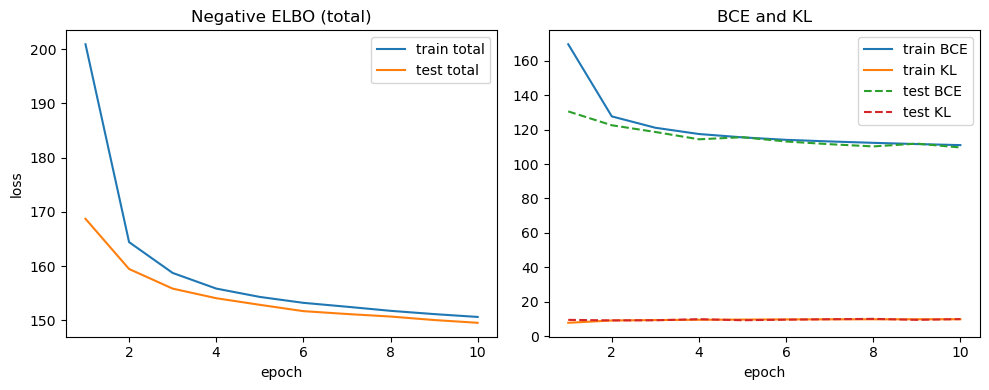

In [ ]:
#Loss curves (Total, BCE, KL)
epochs = np.arange(1, len(history["train_total"])+1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history["train_total"], label="train total")
plt.plot(epochs, history["test_total"],  label="test total")
plt.xlabel("epoch"); 
plt.ylabel("loss"); 
plt.title("Negative ELBO (total)"); 
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history["train_bce"], label="train BCE")
plt.plot(epochs, history["train_kl"],  label="train KL")
plt.plot(epochs, history["test_bce"],  label="test BCE", linestyle="--")
plt.plot(epochs, history["test_kl"],   label="test KL",  linestyle="--")
plt.xlabel("epoch"); 
plt.title("BCE and KL"); 
plt.legend()
plt.tight_layout(); 
plt.show()


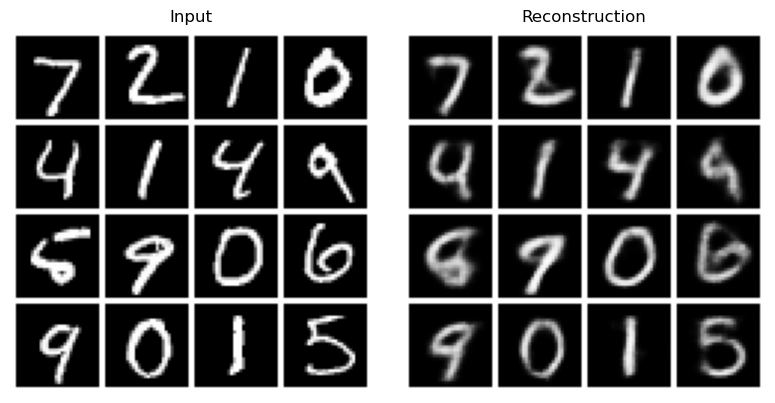

In [ ]:
#Reconstructions (input and reconstruction)
@torch.no_grad()
def show_reconstructions(num_images=16):
    model.eval()
    x, _ = next(iter(test_loader))
    x = x.to(DEVICE)[:num_images]
    logits, _, _ = model(x)
    recon = torch.sigmoid(logits)

    grid_in  = vutils.make_grid(x.cpu(),     nrow=int(math.sqrt(num_images)), pad_value=1.0)
    grid_out = vutils.make_grid(recon.cpu(), nrow=int(math.sqrt(num_images)), pad_value=1.0)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); 
    plt.imshow(grid_in.permute(1,2,0).squeeze(), cmap="gray");  
    plt.axis("off"); 
    plt.title("Input")
    plt.subplot(1,2,2); 
    plt.imshow(grid_out.permute(1,2,0).squeeze(), cmap="gray"); 
    plt.axis("off"); 
    plt.title("Reconstruction")
    plt.tight_layout(); 
    plt.show()
    
show_reconstructions(16)

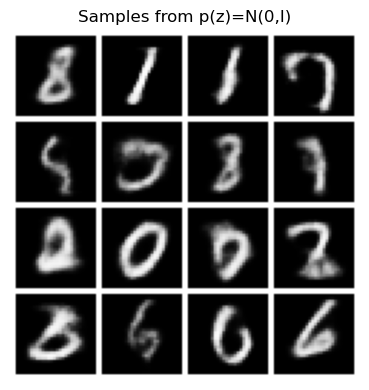

In [ ]:
#Prior sampling (z - N(0, I))
@torch.no_grad()
def sample_prior(num_images=16):
    model.eval()
    z = torch.randn(num_images, LATENT_DIM, device=DEVICE)
    logits = model.decoder(z)
    samples = torch.sigmoid(logits)

    grid = vutils.make_grid(samples.cpu(), nrow=int(math.sqrt(num_images)), pad_value=1.0)
    plt.figure(figsize=(4,4))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
    plt.axis("off"); 
    plt.title("Samples from p(z)=N(0,I)")
    plt.tight_layout(); 
    plt.show()
sample_prior(16)

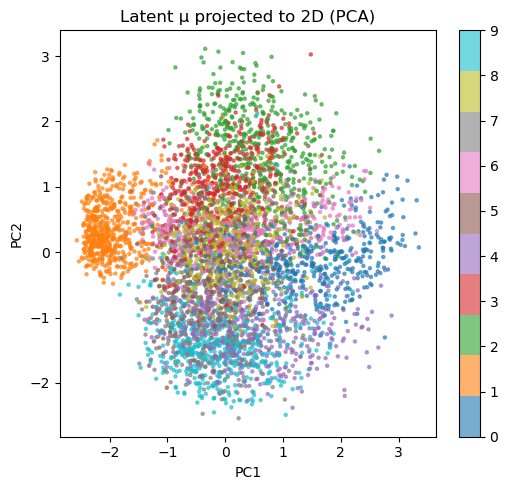

In [ ]:
#Latent 2D (PCA)
@torch.no_grad()
def plot_latent_pca2d(max_points=5000):
    model.eval()
    mus, labels = [], []
    for x, y in test_loader:
        x = x.to(DEVICE)
        mu, _ = model.encoder(x)
        mus.append(mu.cpu())
        labels.append(y)
        if sum(len(a) for a in labels) >= max_points:
            break
    X = torch.cat(mus)[:max_points].numpy() 
    Y = torch.cat(labels)[:max_points].numpy()

    Xc = X - X.mean(0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    Z2 = Xc @ Vt[:2].T  # [N,2]

    plt.figure(figsize=(5.5,5))
    sc = plt.scatter(Z2[:,0], Z2[:,1], c=Y, s=5, alpha=0.6, cmap="tab10")
    plt.colorbar(sc); 
    plt.title("Latent μ projected to 2D (PCA)")
    plt.xlabel("PC1"); 
    plt.ylabel("PC2")
    plt.tight_layout(); 
    plt.show()

plot_latent_pca2d()


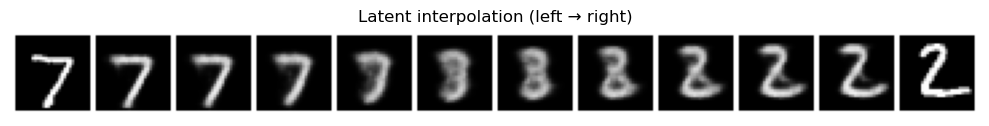

In [ ]:
#Latent interpolation demo
@torch.no_grad()
def latent_interpolation(steps=10, idx_a=0, idx_b=1):
    model.eval()
    x, _ = next(iter(test_loader))
    x = x.to(DEVICE)
    a, b = x[idx_a:idx_a+1], x[idx_b:idx_b+1]
    mu_a, _ = model.encoder(a)
    mu_b, _ = model.encoder(b)

    alphas = torch.linspace(0, 1, steps=steps, device=DEVICE).view(-1,1)
    z_path = (1 - alphas) * mu_a + alphas * mu_b
    imgs = torch.sigmoid(model.decoder(z_path)).cpu()
    row = torch.cat([a.cpu(), imgs, b.cpu()], dim=0)
    grid = vutils.make_grid(row, nrow=steps+2, pad_value=1.0)
    plt.figure(figsize=(10,2))
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray")
    plt.axis("off"); 
    plt.title("Latent interpolation (left → right)")
    plt.tight_layout(); 
    plt.show()
latent_interpolation(steps=10, idx_a=0, idx_b=1)
